<a href="https://colab.research.google.com/github/JoJoPnz/DeepLearning-Tuberculosis-chest-x-ray/blob/main/Project_Tuberculosis_Chest_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/Colab Notebooks/'  #change dir to your project folder

In [ ]:
from google.colab import files
files.upload() #this will prompt you to update the json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen -p /content/gdrive/MyDrive/Colab Notebooks


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks')  #change dir
!unzip -q tuberculosis-chest-xrays-shenzhen.zip

### **Let's Start !**

In [ ]:
!pip install fastai --upgrade
from fastai.vision.all import *
path = Path('/content/gdrive/MyDrive/Colab Notebooks/images/images')

In [ ]:
import pandas as pd 
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks')  #change dir
df=pd.read_csv('./shenzhen_metadata.csv')
df

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal
...,...,...,...,...
657,CHNCXR_0658_1.png,Male,41,bilateral secondary PTB with right pneumothorax
658,CHNCXR_0659_1.png,Male,33,secondary PTB in the left upper field
659,CHNCXR_0660_1.png,Male,50,1.bilateral secondary PTB with right upper atelectasis;2.right pleural adhesions;3.left compensatory emphysema
660,CHNCXR_0661_1.png,Male,26,bilateral secondary PTB with right pleural thickening


In [ ]:
path

Path('/content/gdrive/MyDrive/Colab Notebooks/images/images')

Start with DataLoader (simple one)

In [ ]:
'''
dls = ImageDataLoaders.from_name_func(
    path,  # path to images 
    get_image_files(path), 
    valid_pct=0.2, # randomly split 20% for validation set
    seed=42,  # set seed for image shuffling
    label_func=isCovid,  # get label from this function
    item_tfms=Resize(224)  # apply transformation; resize to 224x224 pixels
)
'''
xray = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(64))

dls = xray.dataloaders(path)

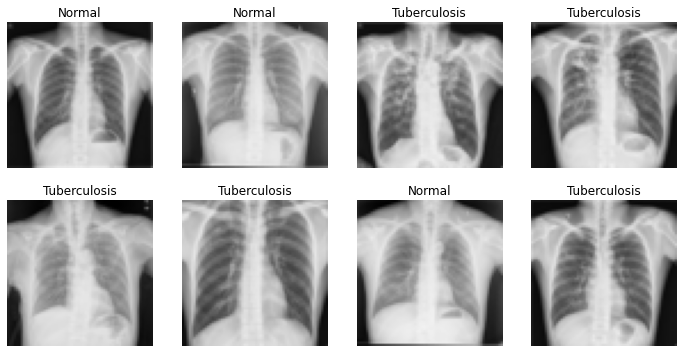

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

Train with no Data Augmentation and LR finder

In [ ]:
xray = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(64))

dls = xray.dataloaders(path)

# Train with resnet50
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(25,cbs=[SaveModelCallback(monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,1.104324,1.248124,0.638655,03:24


Better model found at epoch 0 with accuracy value: 0.6386554837226868.


epoch,train_loss,valid_loss,accuracy,time
0,0.791878,0.725605,0.731092,01:27
1,0.642833,0.756295,0.689076,01:26
2,0.552567,0.833321,0.722689,01:25
3,0.491387,0.803784,0.764706,01:26
4,0.415786,0.700157,0.789916,01:26
5,0.368538,0.978428,0.806723,01:26
6,0.323524,1.198589,0.739496,01:25
7,0.298844,1.149465,0.773109,01:25
8,0.281754,1.269554,0.731092,01:25
9,0.274202,1.372445,0.756303,01:26


Better model found at epoch 0 with accuracy value: 0.7310924530029297.
Better model found at epoch 3 with accuracy value: 0.7647058963775635.
Better model found at epoch 4 with accuracy value: 0.7899159789085388.
Better model found at epoch 5 with accuracy value: 0.8067227005958557.


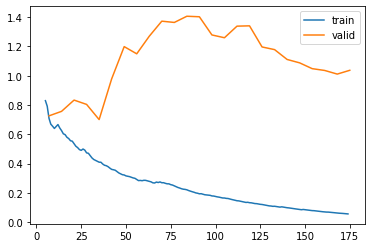

In [ ]:
learn.recorder.plot_loss()

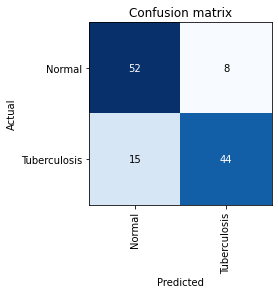

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.export("/content/gdrive/MyDrive/Colab Notebooks/models/firstModel.pkl")

Try Data Augmentation

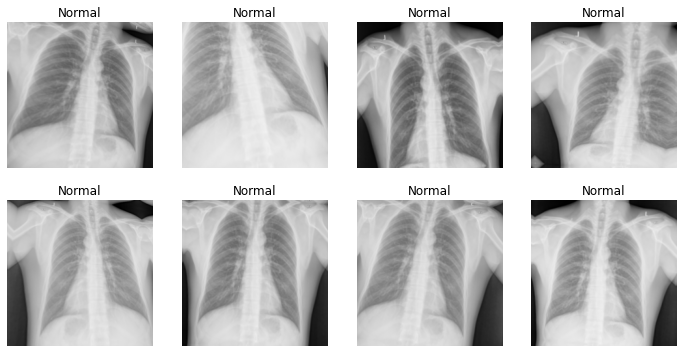

In [ ]:
xray = xray.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = xray.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Train With Only Data Augmentation

epoch,train_loss,valid_loss,accuracy,time
0,1.027776,2.048182,0.546219,01:26


Better model found at epoch 0 with accuracy value: 0.5462185144424438.


epoch,train_loss,valid_loss,accuracy,time
0,0.896086,0.993757,0.630252,01:24
1,0.871606,0.812162,0.672269,01:27
2,0.856909,0.734859,0.672269,01:26
3,0.787629,0.972290,0.630252,01:28
4,0.762171,0.974826,0.697479,01:24
5,0.738371,1.733675,0.663866,01:13
6,0.728688,1.312600,0.630252,01:13
7,0.705005,0.940557,0.747899,01:14
8,0.677024,0.658952,0.789916,01:14
9,0.643308,0.713808,0.823529,01:14


Better model found at epoch 0 with accuracy value: 0.6302521228790283.
Better model found at epoch 1 with accuracy value: 0.6722689270973206.
Better model found at epoch 4 with accuracy value: 0.6974790096282959.
Better model found at epoch 7 with accuracy value: 0.7478991746902466.
Better model found at epoch 8 with accuracy value: 0.7899159789085388.
Better model found at epoch 9 with accuracy value: 0.8235294222831726.
Better model found at epoch 10 with accuracy value: 0.8739495873451233.


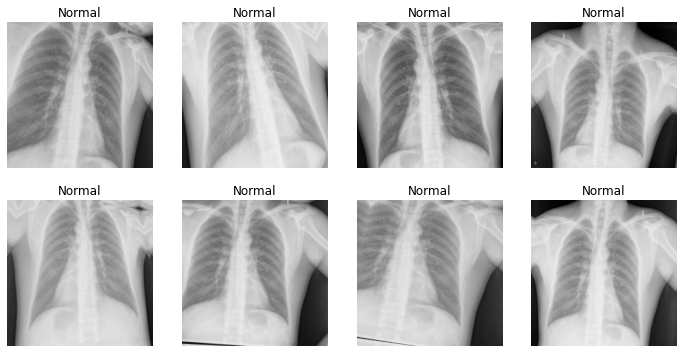

In [ ]:
xray = xray.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = xray.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Train with resnet50
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(20,cbs=[SaveModelCallback(monitor='accuracy')])

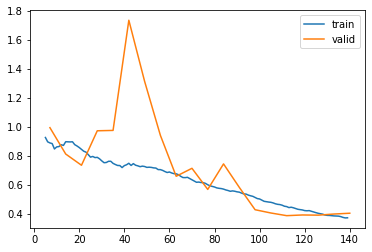

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export("/content/gdrive/MyDrive/Colab Notebooks/models/secondModel.pkl")

Now we try to train with learning rate finder and discriminative learning rate technique

Learning rate finder

SuggestedLRs(valley=0.0030199517495930195)

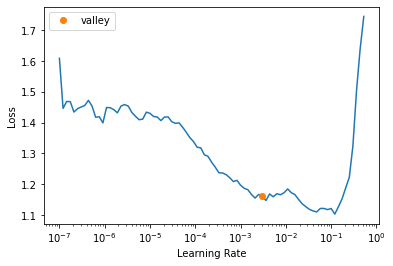

In [ ]:
# create learner
learn = cnn_learner(dls, resnet50, metrics=accuracy)

learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fit_one_cycle(3, 0.0030199517495930195)

epoch,train_loss,valid_loss,accuracy,time
0,1.193958,2.919961,0.529412,01:11
1,1.274510,1.226995,0.680672,01:11
2,1.153265,1.076876,0.663866,01:11


Unfreeze and find learning rate again

SuggestedLRs(valley=0.0002290867705596611)

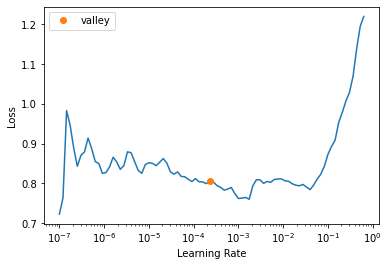

In [ ]:
learn.unfreeze()
learn.lr_find()

Discriminative learning rate

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fit_one_cycle(3, 0.0014454397605732083)
learn.unfreeze()
learn.fit_one_cycle(25, lr_max=slice(0.0002290867705596611,6e-4), cbs=[SaveModelCallback(monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,1.058444,2.964665,0.512605,01:10
1,1.069575,0.818169,0.722689,01:09
2,0.997598,0.645952,0.747899,01:09


epoch,train_loss,valid_loss,accuracy,time
0,0.849305,0.815335,0.722689,01:12
1,0.839825,1.327891,0.663866,01:11
2,0.822035,0.863419,0.722689,01:11
3,0.780488,2.577646,0.621849,01:11
4,0.729393,2.048433,0.638655,01:12
5,0.716908,0.763276,0.789916,01:11
6,0.685510,1.027247,0.840336,01:10
7,0.654988,0.711527,0.739496,01:10
8,0.640297,0.474686,0.815126,01:10
9,0.603115,0.754731,0.773109,01:11


Better model found at epoch 0 with accuracy value: 0.7226890921592712.
Better model found at epoch 5 with accuracy value: 0.7899159789085388.
Better model found at epoch 6 with accuracy value: 0.8403361439704895.
Better model found at epoch 15 with accuracy value: 0.8739495873451233.
Better model found at epoch 18 with accuracy value: 0.8823529481887817.
Better model found at epoch 19 with accuracy value: 0.9075630307197571.


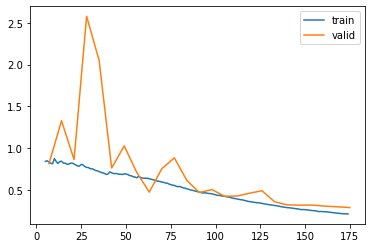

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export("/content/gdrive/MyDrive/Colab Notebooks/models/thirdModel.pkl")

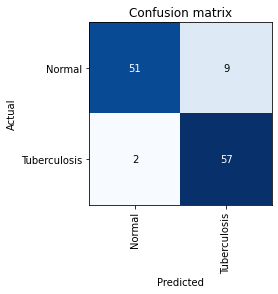

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Use third model to predict the test set



In [ ]:
learner = load_learner("/content/gdrive/MyDrive/Colab Notebooks/models/thirdModel.pkl")

In [ ]:
path = Path("/content/gdrive/MyDrive/Colab Notebooks/test set")
all_images = get_image_files(path)

correct_pred = 0
wrong_pred = 0


for im in all_images:
  result = learner.predict(im)[0][:]
  if(result == "Normal" and im.name[-5] == "0"):
    correct_pred += 1
  elif(result == "Tuberculosis" and im.name[-5] == "1"):
    correct_pred += 1
  else:
    wrong_pred += 1

print("correct_predict = ", correct_pred)
print("wrong_predict = ", wrong_pred)
print("accuracy = " + str( (correct_pred/(correct_pred+wrong_pred))*100 )  + " %" )

correct_predict =  59
wrong_predict =  6
accuracy = 90.76923076923077 %
